# Importing functions and data

## file locations

In [1]:
table_S1 = '../supplementary_tables/TableS1_epistasis_all_double_mutants.xlsx'
gfp_data = '../additional_data/gfp_kondrashov/gfp_epistasis.csv'
fosjun_xtal = '../additional_data/fosjun_docking/experimental_structure/1FOS_fosjun.pdb'

In [2]:
! mkdir ../results/
! mkdir ../results/plots/
! mkdir ../results/tables/
! mkdir ../results/plots/fitness_distributions
! mkdir ../results/plots/data_completeness
! mkdir ../results/plots/epi_dists
! mkdir ../supplementary_figures/secondary_structure
! mkdir ../additional_data/gb1_subsampling/precision

mkdir: ../results/: File exists
mkdir: ../results/plots/: File exists
mkdir: ../results/tables/: File exists
mkdir: ../results/plots/fitness_distributions: File exists
mkdir: ../results/plots/data_completeness: File exists
mkdir: ../results/plots/epi_dists: File exists
mkdir: ../supplementary_figures/secondary_structure: File exists
mkdir: ../additional_data/gb1_subsampling/precision: File exists


## imports

Required python modules, and custom scripts are in "DMS_to_3D.py"

In [3]:
from DMS_to_3D import *
sns.set_style('whitegrid')
%matplotlib inline

## load in mutation scans

load in paper datasets from supplemental table

In [4]:
epistasis_tables = pd.ExcelFile(table_S1)

gb1 = load_sheet(epistasis_tables, 1)
ww = load_sheet(epistasis_tables, 2)
rrm = load_sheet(epistasis_tables, 3)
twister = load_sheet(epistasis_tables, 4)
fosjun = load_sheet(epistasis_tables, 5)

load in GFP dataset from additional data

In [5]:
gfp = pd.read_csv(gfp_data)
gfp.loc[:, 'mut'] = gfp['mut'].apply(lambda x: x.split(','))
gfp.loc[:, 'positions'] = gfp['positions'].apply(eval)
gfp.loc[:, 'lnWs'] = gfp['lnWs'].apply(eval)
gfp.loc[:, 'lnW.proj'] = gfp['lnWs'].apply(np.sum)
gfp.loc[:, 'mut.i'] = gfp['mut'].apply(lambda x: x[0][-1])
gfp.loc[:, 'mut.j'] = gfp['mut'].apply(lambda x: x[1][-1])
gfp.loc[:, 'A_i'] = gfp['mut'].apply(lambda x: x[0][0])
gfp.loc[:, 'A_j'] = gfp['mut'].apply(lambda x: x[1][0])

label long-range mutants, and filter out early stop mutants

In [366]:
# label the long-range mutants
for dms in [gb1, ww, rrm, twister, fosjun, gfp]:
    dms.loc[:, 'LR'] = dms['positions'].apply(lambda x: np.abs(x[1] - x[0]) > 5)

# exclude early stop mutations
ww = ww[~ww['mut'].apply(lambda x: '*' in str(x))]
rrm = rrm[~rrm['mut'].apply(lambda x: '*' in str(x))]

In [7]:
fosjun.loc[:, 'fit.proj.thermo'] = fosjun['double.mut.fit'] - fosjun['mepi_thermo']

fosjun.loc[:, 'Ws'] = fosjun.apply(
    lambda x: (x['fos.mut.fit'], x['jun.mut.fit']),
axis = 1)

## load in example xtal structures

For comparison, for each residue-residue pair in experimental structures, load in the nearest distances between heavy atoms.

In [9]:
gb1_pdbs = [('1gb1', 'A', 226), ('1igd', 'A', 226-5),
            ('1pga', 'A', 226), ('1pgb', 'A', 226),
            ('2gb1', 'A', 226), ('2igd', 'A', 226-5),
            ('2igh', 'A', 226-5), ('2lgi', 'A', 226),
            ('2n7j', 'A', 226), ('3gb1', 'A', 226),
            ('3mp9', 'A', 226-8)]
ww_pdbs =  [('1jmq', 'A', 0), ('4rex', 'A', -160),
            ('1k5r', 'A', 0), ('2lax', 'A', 0),
            ('2lay', 'A', 0), ('2ltw', 'A', 0)]
rrm_pdbs = [('1cvj', 'A', 27)]
gfp_pdbs = [('1ema', 'A', 0)]
twister_pdbs = [('4oji', 'A', 0)]
fosjun_pdbs = [(fosjun_xtal, 'E', 0)]

gb1_xtals = get_dists(gb1_pdbs, gb1)
ww_xtals = get_dists(ww_pdbs, ww)
rrm_xtals = get_dists(rrm_pdbs, rrm)
gfp_xtals = get_dists(gfp_pdbs, gfp)
twister_xtals = get_dists(twister_pdbs, twister)
fosjun_xtals = get_dists(fosjun_pdbs, fosjun)
fosjun = fosjun.rename(columns = {'dist.'+fosjun_pdbs[0][0]: 'dist.1fos'})

Concerning Fos-Jun, the distances to compare against are across the dimer. For convenience, we use a pdb file where the relevant region of Fos is indexed 1-32 and that of Jun is 33-64 (additional data).

## Computing fitness from mutational scan data

The data is typically acquired as some form of pre- and post-selection abundance (e.g. 'input' and 'output' counts). 
Fitness under the selection pressure can be found by comparing the enrichment (e.g. input / output) of a mutant to that of the wild-type (e.g. normalize by WT).  
We use the same fitness metrics as computed by the authors of each study:
- GB1 (Olson et al.), log enrichment in sequence counts corresponding to individual proteins
- WW (Araya et al.) slope fit to log enrichment over 3 rounds of selection of bacteriophage
- RRM (Melamed et al.) log enrichment in sequence counts corresponding to yeast grown in competition
- Fos-Jun (Diss and Lehner) log enrichment in sequence counts (scaled by OD) corresponding to yeast grown in competition
- Twister ribozyme (Kobori and Yokobashi) log fraction of cleaved sequences

## Computing epistasis from fitness

Epistasis is generally computed as the deviation in double mutant fitness from that expected by a model projected from the composite single mutations.  
The better the projection approximates the effect of independent mutations, the more the computed epistasis should reflect true genetic interactions.  
The authors in most of the above studies either chose to project fitness with the multiplicative model because of its conceptual agreement with the nature of their measurement, or tried multiple possible models and found that model to be the best projection of double mutant fitness.  

The one exception is the Diss and Lehner, who also fit a specific thermodynamic model to their data- and found this to result in less systematic error in projecting double mutant fitness. In that case, we use their computed epistasis, expecting it to be better reflective of true genetic interactions.  

In all other cases, we have used the multiplicative model $ \epsilon = lnW_{AB} - lnW_A - lnW_B $  
though we anticipate specific thermodynamic models could improve the precision of epistasis values in reflecting 3D interactions.

# Fitness distributions

## Visualizing measurement floors, continuity VS bimodality, and model efficacy in projecting double mutants

The very large datasets (GB1, Fos-Jun) take quite a while to plot, so here we just plot WW as an example:

In [443]:
def plot_double_fitness(dms, fit='lnW', proj='lnW.proj', fits='lnWs', epi='epi',
                       mi='mut.i', mj='mut.j', outfile=None):
    '''plot double mutant fitness VS projection,
    and distributions of double/single mutant fitnesses'''
    fig = plt.figure(figsize=(10, 5))
    axs = [fig.add_subplot(x) for x in [(321), (323), (122), (325)]]
    singles_i = dms.drop_duplicates(mi).set_index(mi)
    singles_i = singles_i[fits].apply(lambda x: x[0])
    singles_j = dms.drop_duplicates(mj).set_index(mj)
    singles_j = singles_j[fits].apply(lambda x: x[1])
    singles = pd.concat([singles_i, singles_j]).reset_index().drop_duplicates('index')
    
    print(singles.head(), singles_i.head())
    axs[0].hist(singles[fits].dropna(), bins=20)
    axs[1].hist(dms[fit].dropna(), bins=20)

    measd = ~dms[proj].isnull() & ~dms[fit].isnull()
    axs[3].hist(dms.loc[measd, epi], bins=20)

    scatter_density(dms.loc[measd, proj], dms.loc[measd, fit], axs[2])
    x = [np.nanmin(dms[proj]), np.nanmax(dms[proj])]
    axs[2].plot(x, x,'--k', lw=2)
    d = dms[~dms[proj].isnull() & ~dms[fit].isnull()]
    grad, interc, r_val, p_val, std = stats.linregress(d[proj], d[fit])
    axs[2].legend(['model: r value = ' + str(r_val)[:5],
                   'measured'])
    
    axs[0].set_xlabel('single mutant fitness')
    axs[0].set_ylabel('# of single mutants')
    axs[1].set_xlabel('double mutant fitness')
    axs[1].set_ylabel('# of double mutants')
    axs[2].set_xlabel('projected double mutant fitness')
    axs[2].set_ylabel('double mutant fitness')
    axs[3].set_xlabel('double mutant epistasis')
    axs[3].set_ylabel('# of double mutants')
    fig.tight_layout()
    
    if not outfile is None:
        fig.savefig(outfile, dpi=300)

In [434]:
gb1.keys()

Index(['mut', 'positions', 'mut.aminos', 'wt.aminos', 'lnW', 'lnWs',
       'lnW.proj', 'lnW.cap', 'epi', 'Input Count', 'Selection Count',
       'rel_enrich', 'i', 'A_i', 'mut.i', 'j', 'A_j', 'mut.j', 'LR',
       'dist.1gb1', 'dist.1igd', 'dist.1pga', 'dist.1pgb', 'dist.2gb1',
       'dist.2igd', 'dist.2igh', 'dist.2lgi', 'dist.2n7j', 'dist.3gb1',
       'dist.3mp9', 'dist.any_struct', 'epi.abs'],
      dtype='object')

In [452]:
gfp['lnW.proj'] = gfp['lnWs'].apply(np.sum)

In [449]:
gfp['lnWs'].head().iloc[0]

'[-0.010733924270000195, 0.03918137267999988]'

  index      lnWs
0     G -0.010734
1     S  0.153758
2     T -0.581820
3     V -0.171416
4     P -0.032710 mut.i
G   -0.010734
S    0.153758
T   -0.581820
V   -0.171416
P   -0.032710
Name: lnWs, dtype: float64


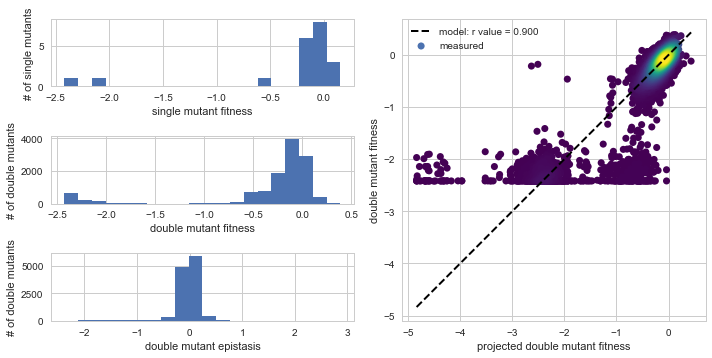

In [453]:
plot_double_fitness(gfp, outfile='../results/plots/fitness_distributions/gfp_fit2.png')

mkdir: ../results/plots/fitness_distributions: File exists


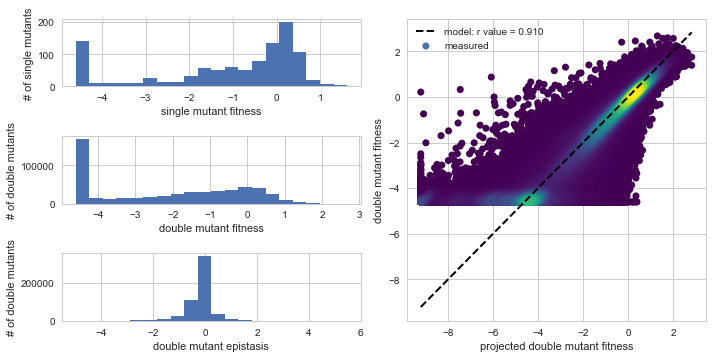

In [1220]:
plot_double_fitness(ww, outfile='../results/plots/fitness_distributions/ww_fit.png')

#plot_double_fitness(gb1, outfile='../results/plots/fitness_distributions/gb1_fit.png')
#plot_double_fitness(rrm, outfile='../results/plots/fitness_distributions/rrm_fit2.png')
#plot_double_fitness(fosjun, fit='double.mut.fit', proj='fit.proj.thermo', epi='mepi_thermo',
#                    fits='Ws', outfile='../results/plots/fitness_distributions/fosjun_fit.png')#
#plot_double_fitness(twister, outfile='../results/plots/fitness_distributions/twister_fit2.png')

# Data completeness

## Visualizing the completeness of each mutant scan, and local abscences in measurement coverage

Plotting just a few mutant coverage maps as examples:

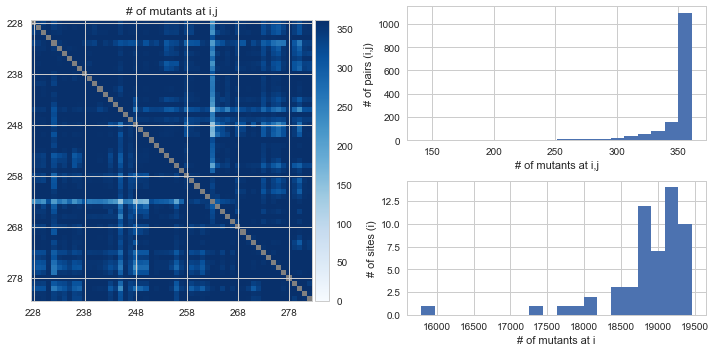

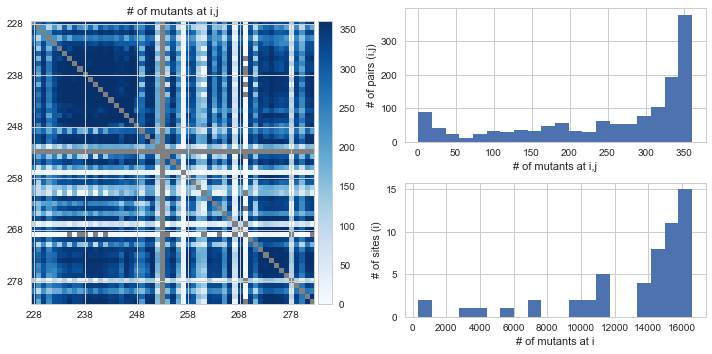

In [46]:
plot_mutant_coverage(gb1[gb1['Input Count'].gt(20)], np.arange(228, 282+1),
    outfile='../results/plots/data_completeness/gb1_inputGT20_coverage.png')


# many GB1 measurements likely obscure true epistasis- because they hit the measurement floor
plot_mutant_coverage(gb1[gb1['Input Count'].gt(20)
                         & gb1['lnWs'].apply(lambda x: x[0] > -4.5 and x[1] > -4.5)
                         & gb1['lnW'].gt(-4.5)], np.arange(228, 282+1),
    outfile='../results/plots/data_completeness/gb1_notMeasurementFloor_coverage.png')

#plot_mutant_coverage(ww, np.arange(170, 203+1),
#    outfile='../results/plots/data_completeness/ww_coverage.png')
#plot_mutant_coverage(rrm, np.arange(126, 199+1),
#    outfile='../results/plots/data_completeness/rrm_coverage.png')
#plot_mutant_coverage(twister, np.arange(7, 54+1), [0, 9],
#    outfile='../results/plots/data_completeness/twister_coverage.png')
#plot_mutant_coverage(fosjun, np.arange(1, 64+1),
#    outfile='../results/plots/data_completeness/fosjun_coverage.png')
#plot_mutant_coverage(gfp, np.arange(1, 235+1), n = 25,
#    outfile='../results/plots/data_completeness/gfp_coverage.png')

# Predicting 3D contacts from experimental epistasis

## Contact prediction method-- the i,j pairs with largest measured epistasis in any double mutant

The method for predicting contacts is very simple:
1. sort all double mutants by measured epistasis
2. keep only the top most epistatic mutant at each i,j site

The highest ranking ('top') i,j sites are therefore those with the strongest epistasis at any mutant measured at that site.  
These are the pairs we suspect are most likely in contact.

In [9]:
def most_epistatic_pairs(epi_table, epi='epi', sign='positive'):
    '''finds the double mutant with highest epistasis at each i-j pair'''

    top_pairs = epi_table.sort_values(epi, ascending=(sign != 'positive'))
    top_pairs = top_pairs.drop_duplicates('positions', keep='first')
    
    # record-keeping detail: how many mutants were measured at each site?
    num_pairs = epi_table.groupby('positions')['mut'].apply(len)
    num_pairs = num_pairs.reset_index().rename(columns = {'mut': 'num.muts'})
    top_pairs = pd.merge(top_pairs, num_pairs, on='positions')
    
    return(top_pairs)

### We found top pairs according to positive epistasis to correspond most strongly to 3D contacts:

In [367]:
gb1_top = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)])
ww_top = most_epistatic_pairs(ww)
rrm_top = most_epistatic_pairs(rrm, epi='Capped_Epistasis_score')
fosjun_top = most_epistatic_pairs(fosjun, 'mepi_thermo')
twister_top = most_epistatic_pairs(twister)
gfp_top = most_epistatic_pairs(gfp)

### Top pairs according to absolute and negative epistasis:

In [368]:
for dms in [gb1, ww, twister, gfp]:
    dms.loc[:, 'epi.abs'] = dms['epi'].apply(np.abs)

rrm.loc[:, 'epi.abs'] = rrm['Capped_Epistasis_score'].apply(np.abs)
fosjun.loc[:, 'epi.abs'] = fosjun['mepi_thermo'].apply(np.abs)


gb1_abs = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)], epi='epi.abs')
ww_abs = most_epistatic_pairs(ww, epi='epi.abs')
rrm_abs = most_epistatic_pairs(rrm, epi='epi.abs')
fosjun_abs = most_epistatic_pairs(fosjun, epi='epi.abs')
twister_abs = most_epistatic_pairs(twister, epi='epi.abs')
gfp_abs = most_epistatic_pairs(gfp, epi='epi.abs')

gb1_neg = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)], sign='negative')
ww_neg = most_epistatic_pairs(ww, sign='negative')
rrm_neg = most_epistatic_pairs(rrm, epi='Capped_Epistasis_score', sign='negative')
fosjun_neg = most_epistatic_pairs(fosjun, epi='mepi_thermo', sign='negative')
twister_neg = most_epistatic_pairs(twister, sign='negative')
gfp_neg = most_epistatic_pairs(gfp, sign='negative')

## Top epistasis pair distribution

In [370]:
gb1_abs.keys()

Index(['mut', 'positions', 'mut.aminos', 'wt.aminos', 'lnW', 'lnWs',
       'lnW.proj', 'lnW.cap', 'epi', 'Input Count', 'Selection Count',
       'rel_enrich', 'i', 'A_i', 'mut.i', 'j', 'A_j', 'mut.j', 'LR',
       'dist.1gb1', 'dist.1igd', 'dist.1pga', 'dist.1pgb', 'dist.2gb1',
       'dist.2igd', 'dist.2igh', 'dist.2lgi', 'dist.2n7j', 'dist.3gb1',
       'dist.3mp9', 'dist.any_struct', 'epi.abs', 'num.muts'],
      dtype='object')

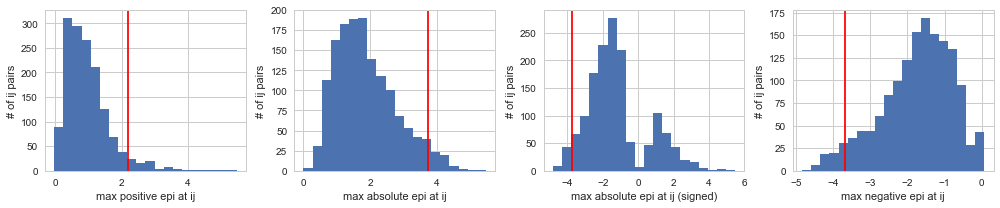

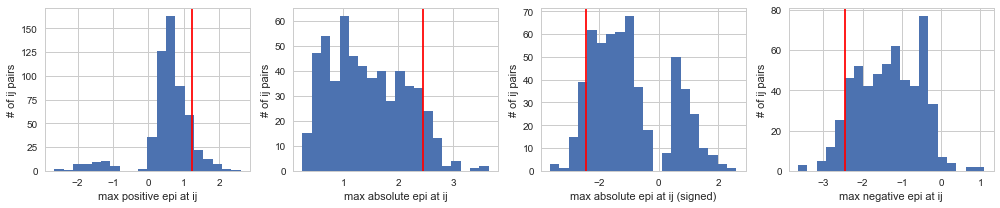

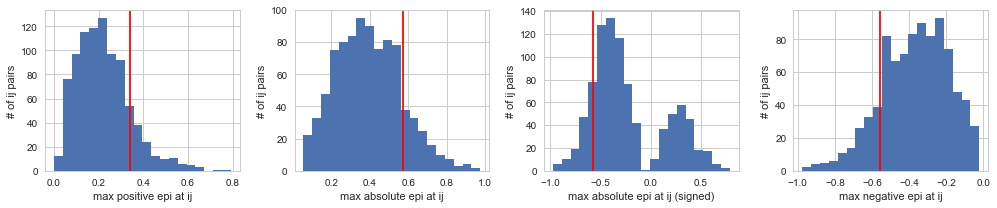

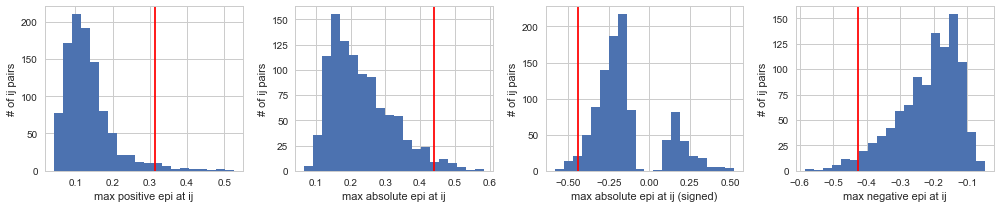

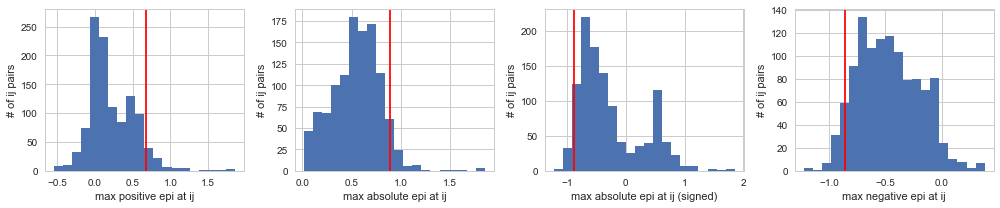

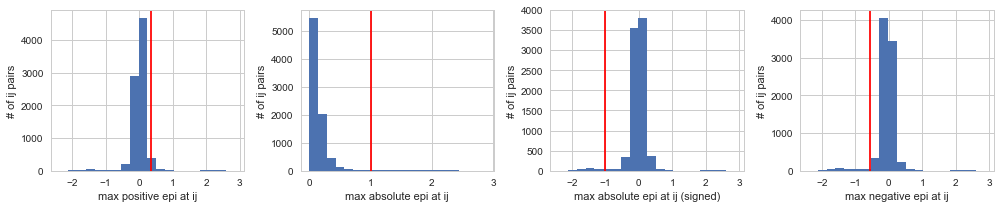

In [375]:
# for each dataset, iterate over the top pairs by positive, absolute, and negative epi
epi_pairs = [
    (gb1_top, gb1_abs, gb1_abs, gb1_neg),
    (ww_top, ww_abs, ww_abs, ww_neg),
    (rrm_top, rrm_abs, rrm_abs, rrm_neg),
    (fosjun_top, fosjun_abs, fosjun_abs, fosjun_neg),
    (twister_top, twister_abs, twister_abs, twister_neg),
    (gfp_top, gfp_abs, gfp_abs, gfp_neg)
]

Ls = [56, 37, 75, 32, 48, 236]
es = ['epi', 'epi.abs', 'epi', 'epi']
rrm_es = ['Capped_Epistasis_score', 'epi.abs',
          'Capped_Epistasis_score', 'Capped_Epistasis_score']
fosjun_es = ['mepi_thermo', 'epi.abs',
             'mepi_thermo', 'mepi_thermo']

list_es = [es, es, rrm_es, fosjun_es, es, es]

ts = ['max positive epi at ij', 'max absolute epi at ij',
     'max absolute epi at ij (signed)', 'max negative epi at ij']

flder = '../results/plots/epi_dists/'
outs = ['gb1', 'ww', 'rrm', 'fosjun', 'twister', 'gfp']

for v, out, L, Es in zip(epi_pairs, outs, Ls, list_es):
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(14, 3)
    for x, ax, t, e in zip(v, axs, ts, Es):
        ax.hist(x[e].dropna(), bins=20);
        ax.set_xlabel(t)
        ax.set_ylabel('# of ij pairs')
        ax.axvline(x[x['LR']][e].iloc[L-1], color='red')
    fig.tight_layout()
    fig.savefig(flder + out + '_max_epi_dists--w_cutoff.png', dpi=300)

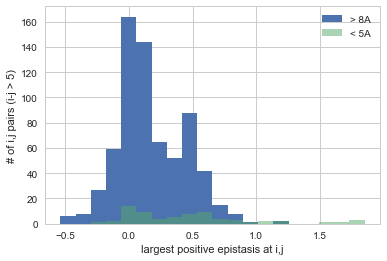

In [23]:
x = twister_top[twister_top['LR']]
e = 'epi'

fig, ax = plt.subplots(1)
bins = np.histogram(x[e], bins=20)
bins = ax.hist(x[x['dist.any_struct'].gt(8)][e], bins=bins[1])
ax.hist(x[x['dist.any_struct'].lt(5)][e], bins=bins[1], alpha=0.5)
ax.legend(['> 8A', '< 5A'])
ax.set_xlabel('largest positive epistasis at i,j')
ax.set_ylabel('# of i,j pairs (i-j > 5)')
fig.savefig('../twister--max_epi_pair--contact_vs_8Anoncontact.svg')

## Epistasis maps

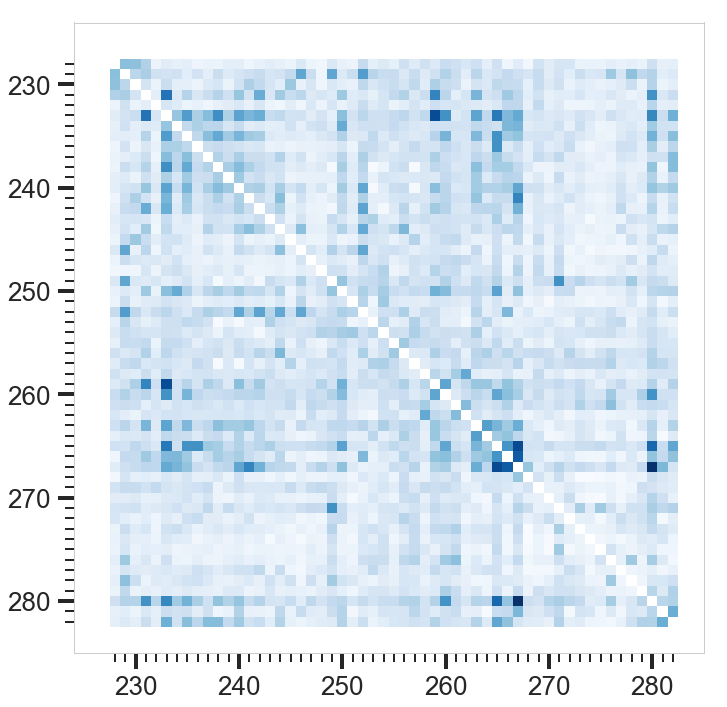

In [158]:
fig, ax, hmap = epi_map(gb1_top, [226, 282], tixm=(228, 283), tixM=(230, 290))
ax.tick_params(width=4, length=16, which='major')
ax.tick_params(width=2, length=9, which='minor')
fig.set_size_inches(10, 10)
fig.tight_layout()

plt.grid(True, which='major')
fig.savefig('../figures/Figure1_top_epi_vals_10grid-b10.svg')

plt.grid(True, which='minor')
fig.savefig('../figures/Figure1_gb1_top_epi_vals_full_grid-b10.svg')

plt.grid(False, which='major')
plt.grid(False, which='minor')
fig.savefig('../figures/Figure1_gb1_top_epi_vals_NOgrid-b10.svg')

## Comparing top epistasis pairs to 3D distances

In [333]:
def compare_contacts(X, Y, Z, d, D, name, Ns,
                     lims, tixM, tixm, tN=10, o=0, oL=0, s=300):#, Lo=0):
    '''plot epi pairs versus crystal structures'''
    M = len(set(Z['positions']))
    n = np.sum(Z.drop_duplicates('positions')['dist.any_struct'].lt(5))
    
    for N in Ns:
        plt.close()
        fig, ax = plotContacts(X, lims=lims, dist=d, tixM=tixM, tixm=tixm,
                               n=tN, offset=o, s=s, label_offset=oL)
        plotIJ(Y.head(N), ax=ax, z=2, s=100, offset=o)
        ax.tick_params(width=4, length=16, which='major')
        ax.tick_params(width=2, length=9, which='minor')
        hits = np.sum(Y.head(N)[D].lt(5))
        pv = hypergeom.sf(hits-1, M, n, N)
        pv = '%.2E' % pv

        ax.set_title('top '+str(N)+' epistasis pairs ('+str(hits)+
                     ' true contacts; p-value: '+pv+')', fontsize=20)

        fig.savefig('../supplementary_figures/epi_contacts/'+name+
                    '/'+name+'--top_'+str(N)+'_epi_pairs.svg')
    

In [334]:
def plotContacts(df, ax=None, s=300, offset=0, dist='min_overall',
                 c1='#e3eef8', c2='#96c4de', lims=None, tixm=None, tixM=None,
                 buff=2, alpha=1, d1=8, d2=5, n=10, label_offset=0):
    '''scatter plot i,j pairs within 8A, and 5A'''

    if ax is None:
        fig, ax = plt.subplots(1)
        fig.set_size_inches(10,10)
    else:
        fig = None

    if lims is None:
        x = df['positions'].apply(lambda x: x[0])
        lims = [np.min(x), np.max(x)]

    inlim = df['positions'].apply(lambda x: in_lim(x, lims))

    plotIJ(df[df[dist].lt(d1) & inlim],
           color=c1, s=s, alpha=alpha, ax=ax, z=0)
    plotIJ(df[df[dist].lt(d2) & inlim],
           color=c2, s=s, alpha=alpha, ax=ax, z=1)

    # formatting niceties:
    if tixm is None:
        tixm = lims
    if tixM is None:
        tixM = lims
    tixm = np.arange(*tixm, 1)
    tixM = np.arange(*tixM, n)

    ax.set_xticks(tixm, minor=True)
    ax.set_yticks(tixm, minor=True)
    ax.set_xticks(tixM, minor=False)
    ax.set_yticks(tixM, minor=False)
    ax.set_xticklabels(tixM+label_offset, fontsize=26)
    ax.set_yticklabels(tixM+label_offset, fontsize=26)
    ax.set_xlim(lims[0]-buff, lims[1]+buff)
    ax.set_ylim(lims[0]-buff, lims[1]+buff)
    ax.invert_yaxis()

    return(fig, ax)

In [323]:
#ww_top.head(22)

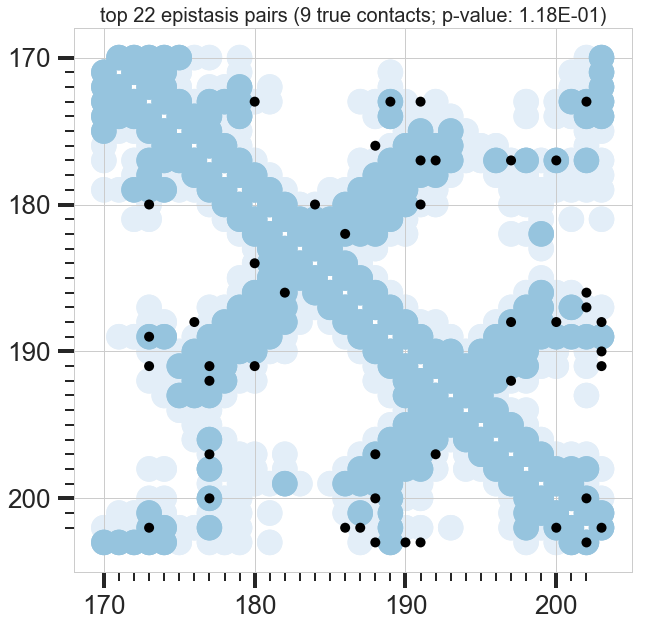

In [335]:
compare_contacts(
    ww_xtals3, ww_top, ww, 'min_overall', 'dist.any_struct', 'ww',
    [22], (10, 43), (10, 50), (10, 43), oL=160, s = 650)

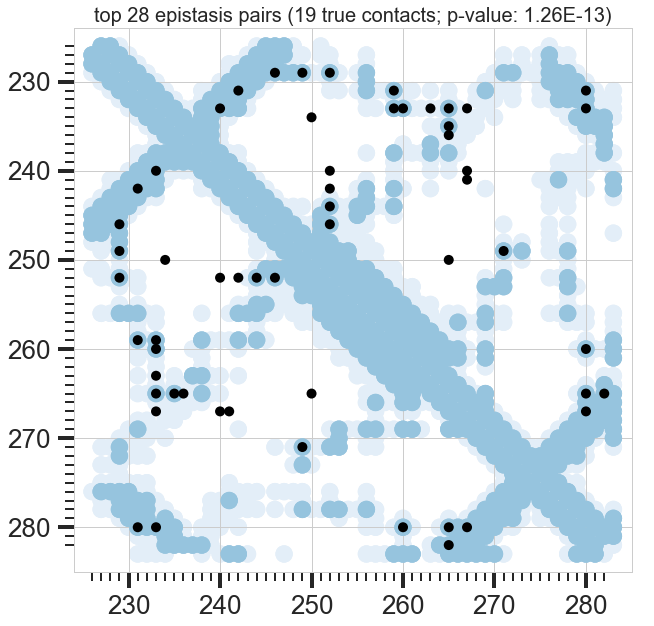

In [311]:
compare_contacts(
    gb1_xtals, gb1_top[gb1_top['LR']], gb1[gb1['LR']], 'min_overall', 'dist.any_struct', 'gb1',
    [28], (226, 283), (230, 290), (226, 283))

In [343]:
rrm_top[rrm_top['LR']].head(13)

,mut,positions,mut.aminos,wt.aminos,W,lnW,lnWs,WaWb,WaWb.cap,Capped_Epistasis_score,...,i,A_i,mut.i,j,A_j,mut.j,LR,dist.1cvj,dist.any_struct,num.muts
1,"[S155W, H172L]","(155, 172)","('W', 'L')","('S', 'H')",0.924745,-0.033978,"[-0.18330143048282255, -0.5531980887517995]",0.183443,0.183443,0.741302,...,155,S,S155W,172,H,H172L,True,7.404233,7.404233,44
3,"[L186V, V198G]","(186, 198)","('V', 'G')","('L', 'V')",1.057117,0.024123,"[0.01795067420681097, -0.46585352724279383]",0.356531,0.356531,0.657905,...,186,L,L186V,198,V,V198G,True,5.171711,5.171711,26
5,"[N132V, N139T]","(132, 139)","('V', 'T')","('N', 'N')",1.175364,0.070172,"[-0.34803683779035816, -0.06754155005424302]",0.384080,0.384080,0.615920,...,132,N,N132V,139,N,N139T,True,12.515593,12.515593,61
6,"[G126C, N139T]","(126, 139)","('C', 'T')","('G', 'N')",1.045663,0.019392,"[-0.347727819727324, -0.06754155005424302]",0.384353,0.384353,0.615647,...,126,G,G126C,139,N,N139T,True,14.490089,14.490089,39
8,"[T159H, F168Y]","(159, 168)","('H', 'Y')","('T', 'F')",0.979553,-0.008972,"[-0.3759100688541079, -0.06033858214007925]",0.366228,0.366228,0.613325,...,159,T,T159H,168,F,F168Y,True,7.467298,7.467298,33
11,"[L153I, G167R]","(153, 167)","('I', 'R')","('L', 'G')",1.299407,0.113745,"[-0.38110476222354556, 0.05687604065638404]",0.473992,0.473992,0.584190,...,153,L,L153I,167,G,G167R,True,15.121290,15.121290,34
13,"[L133A, N139S]","(133, 139)","('A', 'S')","('L', 'N')",0.927690,-0.032597,"[-0.4083763282240304, -0.05326011850416175]",0.345433,0.345433,0.582257,...,133,L,L133A,139,N,N139S,True,6.971710,6.971710,38
14,"[D151A, I157S]","(151, 157)","('A', 'S')","('D', 'I')",0.960431,-0.017534,"[-0.006343541048067329, -0.40031954082185095]",0.392046,0.392046,0.568385,...,151,D,D151A,157,I,I157S,True,14.823672,14.823672,52
17,"[I157L, K166S]","(157, 166)","('L', 'S')","('I', 'K')",1.012871,0.005554,"[-0.01884898017913811, -0.3270195698965416]",0.450953,0.450953,0.549047,...,157,I,I157L,166,K,K166S,True,5.852858,5.852858,44
18,"[K156S, K164R]","(156, 164)","('S', 'R')","('K', 'K')",0.788307,-0.103305,"[-0.5978081721511131, -0.022248698578004298]",0.239852,0.239852,0.548455,...,156,K,K156S,164,K,K164R,True,8.254358,8.254358,49


In [347]:
max(rrm[rrm['i'].eq(153)]['j'])

175

In [349]:
min(twister['i'])

7

In [355]:
np.mean(twister_top.head(24)['dist.any_struct'].lt(5))

0.7083333333333334

In [356]:
np.mean(twister_top[twister_top['LR']].head(24)['dist.any_struct'].lt(5))

0.5

In [357]:
twister_top[twister_top['LR']].head(24).tail(1)

,mut,positions,mut.nucleo,wt.nucleu,W,lnW,lnWs,lnW.proj,lnW.cap,epi,i,A_i,mut.i,j,A_j,mut.j,LR,dist.4oji,dist.any_struct,num.muts
35,"[C14A, C26A]","(14, 26)","('A', 'A')","('C', 'C')",0.06,-1.221849,"[-0.8538719643217619, -1.1549019599857433]",-2.008774,-2.0,0.778151,14,C,C14A,26,C,C26A,True,22.705936,22.705936,9


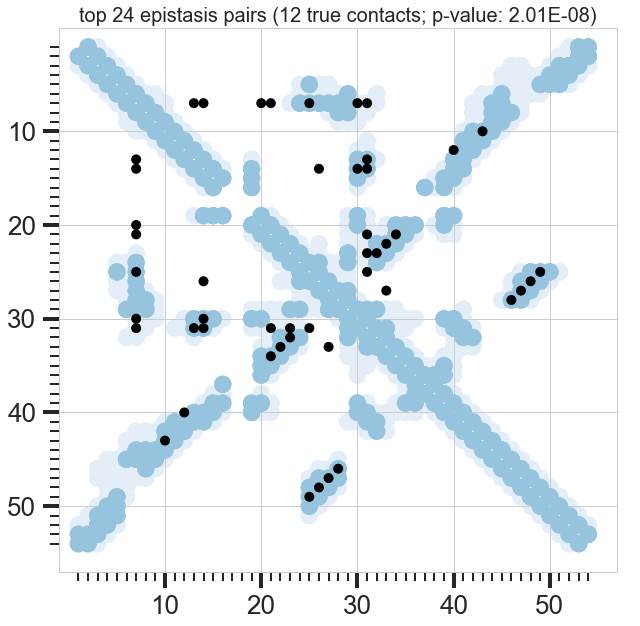

In [359]:
compare_contacts(
    twister_xtals, twister_top[twister_top['LR']], twister[twister['LR']], 'min_overall', 'dist.any_struct', 'twister',
    [24], (1, 55), (10, 60), (1, 55))

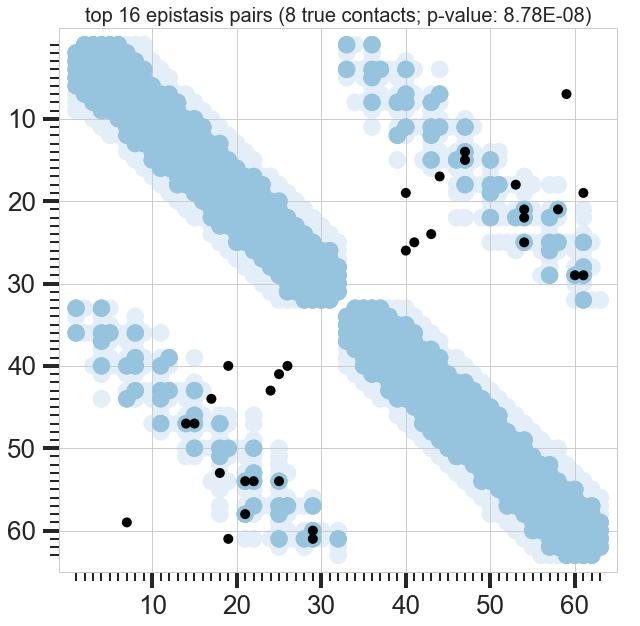

In [360]:
compare_contacts(
    fosjun_xtals, fosjun_top, fosjun, 'min_overall', 'dist.any_struct', 'fosjun',
    [16], (1, 63), (10, 70), (1, 64))

In [361]:
20 / 37

0.5405405405405406

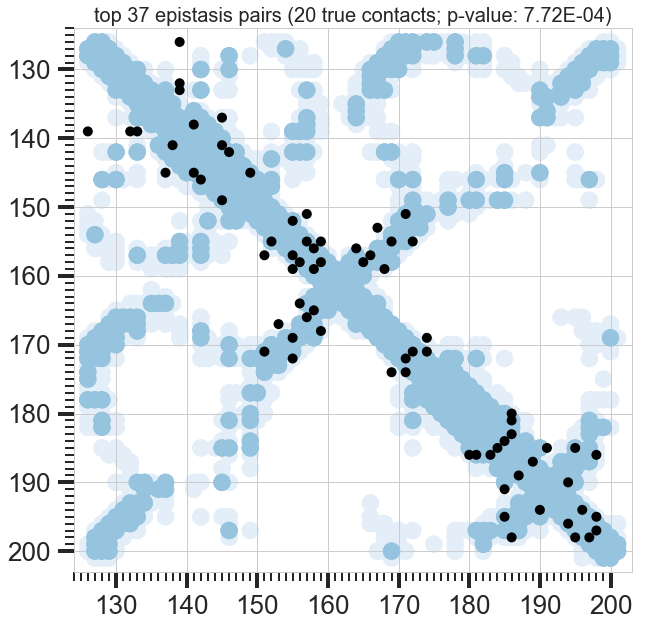

In [344]:
compare_contacts(
    rrm_xtals, rrm_top, rrm, 'min_overall', 'dist.any_struct', 'rrm',
    [37], (126, 201), (130, 210), (120, 201))

In [345]:
rrm_xtals.keys()

Index(['positions', '1cvj', 'min_overall'], dtype='object')

mkdir: ../supplementary_figures/epi_contacts: File exists
mkdir: ../supplementary_figures/epi_contacts/gb1: File exists


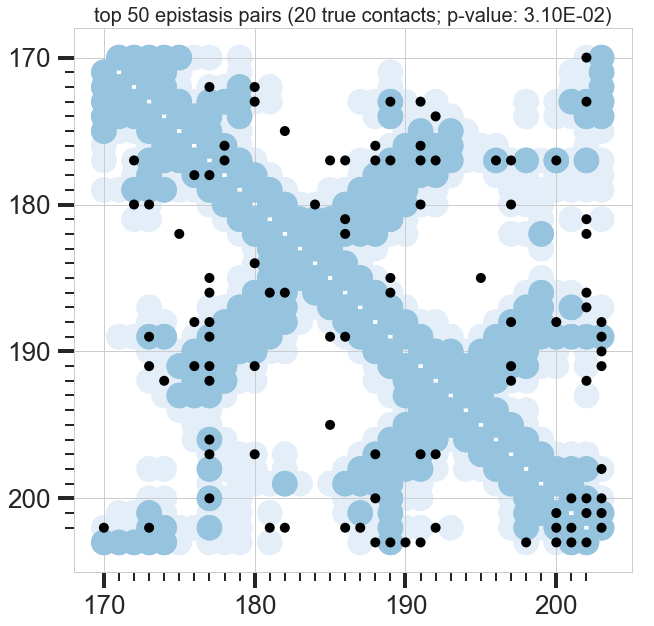

In [336]:
!mkdir ../supplementary_figures/epi_contacts
!mkdir ../supplementary_figures/epi_contacts/gb1
#!mkdir ../supplementary_figures/epi_contacts/ww
#!mkdir ../supplementary_figures/epi_contacts/rrm
#!mkdir ../supplementary_figures/epi_contacts/fosjun
#!mkdir ../supplementary_figures/epi_contacts/twister
#!mkdir ../supplementary_figures/epi_contacts/gfp

#compare_contacts(
#    gb1_xtals, gb1_top, gb1, 'min_overall', 'dist.any_struct', 'gb1',
#    [10, 20, 30, 40, 50, 60, 70, 100], (226, 283), (230, 290), (226, 283))
#compare_contacts(
#    ww_xtals3, ww_top, ww, 'min_overall', 'dist.any_struct', 'ww',
#    [5, 10, 20, 30, 40, 50], (10, 43), (10, 50), (10, 43), oL=160, s = 650)
#compare_contacts(
#    rrm_xtals, rrm_top, rrm, 'min_overall', 'dist.any_struct', 'rrm',
#    [10, 15, 20, 25, 30, 40, 50, 60], (126, 201), (130, 210), (120, 201))
#compare_contacts(
#    fosjun_xtals, fosjun_top, fosjun, 'min_overall', 'dist.any_struct', 'fosjun',
#    [3, 5, 7, 9, 20, 30], (1, 63), (10, 70), (1, 64))
#compare_contacts(
#    twister_xtals, twister_top, twister, 'min_overall', 'dist.any_struct', 'twister',
#    [5, 10, 20, 30, 40, 50], (1, 55), (10, 60), (1, 55))
#compare_contacts(
#    gfp_xtals, gfp_top, gfp, 'min_overall', 'dist.any_struct', 'gfp',
#    [75], (0, 240), (10, 240), (1, 1), tN=20)


## Secondary structure prediction method

### Computing secondary structure score

In [376]:
def compute_SS(epi, fill=np.nan, aparams=[1, 0.723, 0.635, 0.587], bparams=[1, 0.723],
               e='epi', l=1, r=1, bcut=0.75, acut=1.5, nb=2, na=4):
    '''computes SS scores according to Perry's algorithm'''

    epi_i = epi.sort_values('i').drop_duplicates('i')
    epi_ij = epi.set_index(['i', 'j'])[e].astype(float)
    pairs = set(epi_ij.index)
    indices = list(epi_i['i'])

    # complete values where data is missing
    for i in indices:
        for j in np.arange(i+1, i+5):
            if (i, j) not in pairs:
                epi_ij.loc[(i, j)] = fill
        for j in np.arange(i-4, i):
            if (j, i) not in pairs:
                epi_ij.loc[(j, i)] = fill

    std_i1 = np.nanvar(epi_ij.loc[[(i, i+1) for i in indices[:-1]]])
                
    alpha = []
    beta = []

    for i in indices:
        alpha.append(alpha_score(epi_ij, i, std_i1, aparams, l, r))
        beta.append(beta_score(epi_ij, i, std_i1, bparams, l, r))

    scores = pd.DataFrame({
        'i':             indices,
        'seq':           epi_i['A_i'],
        'alpha':         alpha,
        'beta':          beta,
    })

    scores.loc[:, 'alpha_smooth'] = smooth(scores['alpha'], na)
    scores.loc[:, 'beta_smooth'] =  smooth(scores['beta'], nb)

    return(scores)


def alpha_score(epi_ij, i, std_i1, params=[1, 0.723, 0.635, 0.587], l=1, r=1):
    '''computes alpha score as {i+4} - {i+3} - {i+2} + {i+1},
    provided parameters for normalizing each {i+x} (e.g. the
    correlations identified for ECs in Toth-Petroczy et al.)'''
    i1 = (l*epi_ij[(i-1, i)] + r*epi_ij[(i, i+1)]) / (params[0])
    i2 = (l*epi_ij[(i-2, i)] + r*epi_ij[(i, i+2)]) / (params[1])
    i3 = (l*epi_ij[(i-3, i)] + r*epi_ij[(i, i+3)]) / (params[2])
    i4 = (l*epi_ij[(i-4, i)] + r*epi_ij[(i, i+4)]) / (params[3])
    return((i4 + i3 - i2 - i1)/std_i1)


def beta_score(epi_ij, i, std_i1, params=[1, 0.723], l=1, r=1):
    '''computes alpha score as {i+2} - {i+1},
    provided parameters for normalizing each {i+x}'''
    i1 = (l*epi_ij[(i-1, i)] + r*epi_ij[(i, i+1)]) / (params[0])
    i2 = (l*epi_ij[(i-2, i)] + r*epi_ij[(i, i+2)]) / (params[1])
    return((i2 - i1)/std_i1)


def smooth(vals, n=1, offset=None):
    '''average values over a range'''
    vals = list(vals)
    if offset is None:
        offset = int(np.around(n//2)) - 1
    
    sm = [np.nan]*offset
    for i in range(len(vals)-n):
        sm.append(np.mean(vals[i:i+n]))
    sm += [np.nan]*(n-offset)

    return(sm)

### Extract secondary structure regions from experimental structures for comparison

In [95]:
gb1_ss = merge_ss(gb1_pdbs).set_index('id').loc[np.arange(228, 283)]
gb1_ss.to_csv('../supplementary_tables/secondary_scores_vs_xtal_sec_struct.csv')

### Visualization

mkdir: ../supplementary_figures/secondary_structure: File exists
Ttest_indResult(statistic=-3.283613495708188, pvalue=0.0019168694096591205)
Ttest_indResult(statistic=-4.983483585388654, pvalue=1.0182280703737649e-05)


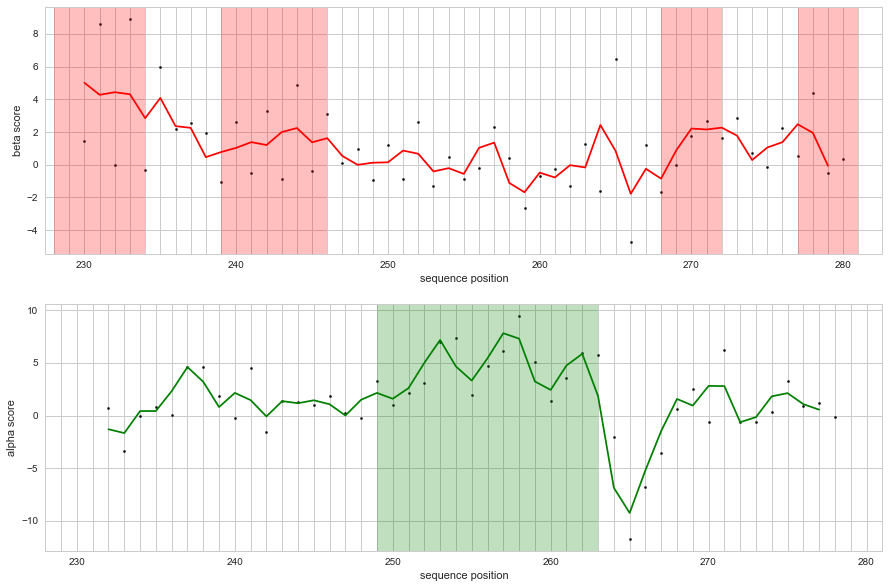

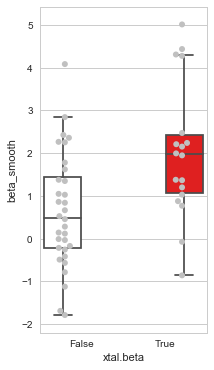

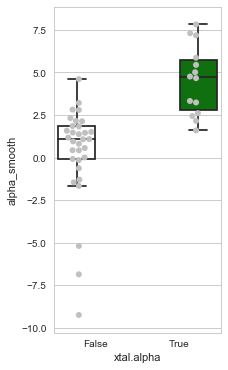

In [306]:
acut = 1.5
bcut = 0.75
scores = compute_SS(gb1_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
                   na=2, nb=2) #aparams=[1,1,1,1], bparams=[1,1], 

fig, ax = plt.subplots(2,1)
fig.set_size_inches(15, 10)
plot_scores(scores, 'beta', 'red', ax[0])
ax[0].set_ylabel('beta score')
plot_scores(scores, 'alpha', 'green', ax[1])
ax[1].set_ylabel('alpha score')


for (a,b) in gb1_betastrands:
    rect = patches.Rectangle((a,-10), b-a, 22, linewidth=1, edgecolor=None, facecolor='red', alpha=0.25)
    ax[0].add_patch(rect)

rect = patches.Rectangle((gb1_helix[0],-30), gb1_helix[1]-gb1_helix[0], 60, linewidth=1, edgecolor=None, facecolor='green', alpha=0.25)
ax[1].add_patch(rect)

gb1_beta_resi = set.union(*[set(np.arange(a, b)) for (a,b) in gb1_betastrands])
gb1_alpha_resi = set(np.arange(*gb1_helix))

#fig.savefig('../supplementary_figures/secondary_structure/score_vs_union_xtal_SS.svg')

fig, ax = plt.subplots(1)
fig.set_size_inches(3, 6)
scores.loc[:, 'xtal.beta'] = scores['i'].apply(lambda x: x in gb1_beta_resi)
scores.loc[:, 'xtal.alpha'] = scores['i'].apply(lambda x: x in gb1_alpha_resi)

my_pal1 = {True: 'red', False: 'white'}
my_pal2 = {True: 'silver', False: 'silver'}
sns.boxplot(x='xtal.beta', y='beta_smooth', hue='xtal.beta',
            data=scores, ax=ax, palette=my_pal1,
            width=0.9, fliersize=0)
sns.swarmplot(x='xtal.beta', y='beta_smooth', hue='xtal.beta',
              data=scores, ax=ax, s=6, palette=my_pal2, split=True)
ax.legend([])

#fig.savefig('../supplementary_figures/secondary_structure/beta_score_in_strands_xtal_union.svg')

fig, ax = plt.subplots(1)
fig.set_size_inches(3, 6)
my_pal1 = {True: 'green', False: 'white'}
sns.boxplot(x='xtal.alpha', y='alpha_smooth', hue='xtal.alpha',
            data=scores, ax=ax, palette=my_pal1,
            width=0.9, fliersize=0)
sns.swarmplot(x='xtal.alpha', y='alpha_smooth', hue='xtal.alpha',
              data=scores, ax=ax, s=6, palette=my_pal2, split=True)
ax.legend([])

#fig.savefig('../supplementary_figures/secondary_structure/alpha_score_in_strands_xtal_union.svg')

z = scores[~scores['beta_smooth'].isnull()]
print(stats.ttest_ind(z[~z['xtal.beta']]['beta_smooth'], z[z['xtal.beta']]['beta_smooth']))
z = scores[~scores['alpha_smooth'].isnull()]
print(stats.ttest_ind(z[~z['xtal.alpha']]['alpha_smooth'], z[z['xtal.alpha']]['alpha_smooth']))

In [379]:
?plot_scores

Signature: plot_scores(scores, x, color='red', ax=None, n=10)
Docstring: plots scores and fill in specified regions
File:      ~/Dropbox (HMS)/DMS_folding/Analysis/submission/notebooks/DMS_to_3D.py
Type:      function


In [382]:
scores.head()

,alpha,beta,i,seq,alpha_smooth,beta_smooth
1242,NaN,NaN,228,Q,NaN,NaN
353,NaN,NaN,229,Y,NaN,NaN
717,NaN,1.420571,230,K,NaN,5.008934
936,NaN,8.597297,231,L,NaN,4.273630
1054,0.726284,-0.050037,232,I,NaN,4.433540


In [404]:
def smooth(vals, n=1):
    '''average values over a range'''
    vals = list(vals)
    
    sm = []
    for i in range(len(vals)-n):
        sm.append(np.mean(vals[i:i+n]))
    sm += [np.nan]*n

    return(sm)

In [5]:
gb1_ss = pd.read_csv('../../../../../Analysis/submission/supplementary_tables/secondary_scores_vs_xtal_sec_struct.csv')

In [9]:
gb1_ss.head()

,id,sec_struct_3state,1igd,1pga,1pgb,2gb1,2igd,2igh,2lgi,2n7j,3gb1,3mp9,joint
0,228,E,E,E,E,E,E,E,E,E,E,E,E
1,229,E,E,E,E,E,E,E,E,E,E,E,E
2,230,E,E,E,E,E,E,E,E,E,E,E,E
3,231,C,E,E,E,E,E,E,E,E,E,E,E
4,232,C,E,E,E,E,E,E,E,E,E,E,E


KeyError: 'i'

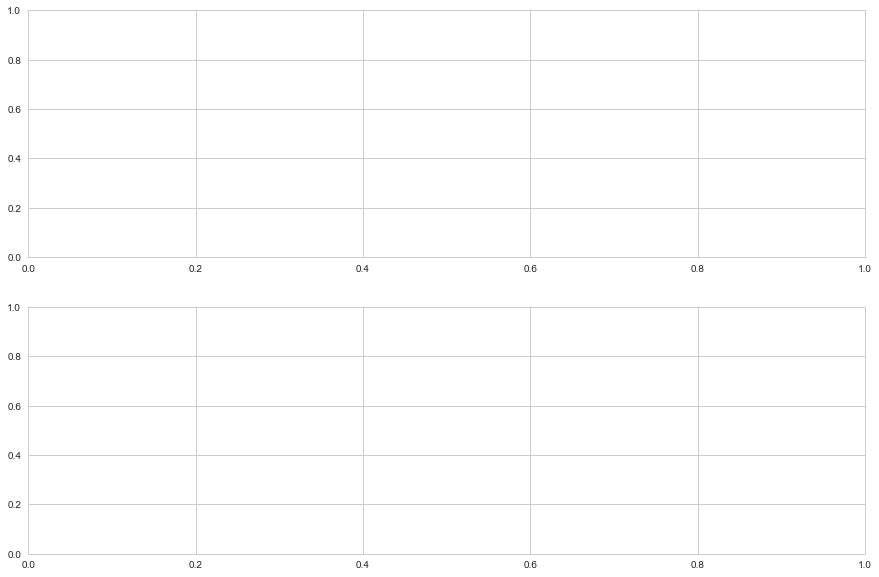

In [7]:
scores = gb1_ss

gb1_betastrands = [(228, 234), (239, 246), (268, 272), (277, 281)]
gb1_helix = (249, 263)

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

#ax[0].scatter(scores['i'], scores['beta'])
ax[0].plot(scores['i'], smooth(scores['beta'], 2), color='black')
    

#ax[1].scatter(scores['i'], scores['alpha'])
ax[1].plot(scores['i'], smooth(scores['alpha'], 4), color='black')



for (a,b) in gb1_betastrands:
    rect = patches.Rectangle((a,-10), b-a, 22, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
    ax[0].add_patch(rect)

rect = patches.Rectangle((gb1_helix[0],-30), gb1_helix[1]-gb1_helix[0], 60, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
ax[1].add_patch(rect)

ax[0].set_xlim(228, 282)
ax[1].set_xlim(228, 282)

n=10
ax[0].set_xticks(np.arange(230, 283, n), minor=False)
ax[1].set_xticks(np.arange(230, 283, n), minor=False)
ax[0].set_xticklabels([]) # np.arange(230, 283, n), minor=False, fontsize=18)
ax[1].set_xticklabels([]) #np.arange(230, 283, n), minor=False, fontsize=18)
ax[0].set_xticks(np.arange(228, 283), minor=True)
ax[1].set_xticks(np.arange(228, 283), minor=True)

ax[0].set_yticks([-4, 0, 4, 8])#, minor=True)
#ax[0].set_yticks([0], minor=True)
#ax[1].set_yticks([0], minor=True)
ax[0].set_yticklabels([-4, 0, 4, 8], fontsize=25)
ax[1].set_yticks([-10, -5, 0, 5, 10])
ax[1].set_yticklabels([-10, -5, 0, 5, 10], fontsize=25)#, minor=True)


ax[0].tick_params(width=2, length=8, which='major')
ax[0].tick_params(width=1, length=5, which='minor')
ax[1].tick_params(width=2, length=8, which='major')
ax[1].tick_params(width=1, length=5, which='minor')

ax[0].grid(False)
ax[1].grid(False)
ax[0].grid(True, which='minor', axis='x')
ax[1].grid(True, which='minor', axis='x')

ax[0].axhline(0, color='gray', lw=1)
ax[1].axhline(0, color='gray', lw=1)

#fig.savefig('../gb1_secondary.svg')


In [387]:
acut = 1.5
bcut = 0.75
scores = compute_SS(gb1_top, e='epi', l=1, r=1, acut=acut, bcut=bcut, nb=1, na=3) #aparams=[1,1,1,1], bparams=[1,1], 

plot_scores(scores, 'beta', 'red')
plot_scores(scores, 'alpha', 'green')

ValueError: Must have equal len keys and value when setting with an iterable

In [207]:
def smooth(vals, n=1):
    sm = []
    for i in range(len(vals)):
        sm.append(np.nanmean(vals[i:i+n]))
    return(sm)

In [200]:
np.sort([1, 5, 10, 19])[-2:] #, 50)

array([10, 19])

In [214]:
scores.loc[:, 'smooth.beta'] = smooth(list(scores['beta']), n=2)
scores.loc[:, 'smooth.alpha'] = smooth(list(scores['alpha']), n=4)

/Users/nrollins/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


Ttest_indResult(statistic=-3.012266407556001, pvalue=0.004094392753745572)
Ttest_indResult(statistic=-5.226053219852332, pvalue=4.318451536980208e-06)


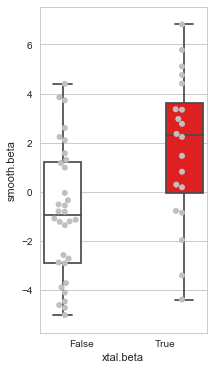

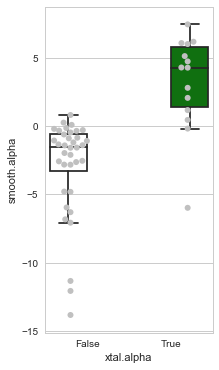

In [217]:
z = scores
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 6)
my_pal1 = {True: 'red', False: 'white'}
sns.boxplot(x='xtal.beta', y='smooth.beta', hue='xtal.beta',
            data=scores, ax=ax, palette=my_pal1,
            width=0.9, fliersize=0)
sns.swarmplot(x='xtal.beta', y='smooth.beta', hue='xtal.beta',
              data=scores, ax=ax, s=6, palette=my_pal2, split=True)
ax.legend([])



z = scores
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 6)
my_pal1 = {True: 'green', False: 'white'}
sns.boxplot(x='xtal.alpha', y='smooth.alpha', hue='xtal.alpha',
            data=scores, ax=ax, palette=my_pal1,
            width=0.9, fliersize=0)
sns.swarmplot(x='xtal.alpha', y='smooth.alpha', hue='xtal.alpha',
              data=scores, ax=ax, s=6, palette=my_pal2, split=True)
ax.legend([])

#fig.savefig('../supplementary_figures/secondary_structure/alpha_score_in_strands_xtal_union.svg')

z = scores[~scores['beta'].isnull()]
print(stats.ttest_ind(z[~z['xtal.beta']]['smooth.beta'], z[z['xtal.beta']]['smooth.beta']))
z = scores[~scores['alpha'].isnull()]
print(stats.ttest_ind(z[~z['xtal.alpha']]['smooth.alpha'], z[z['xtal.alpha']]['smooth.alpha']))

/Users/nrollins/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


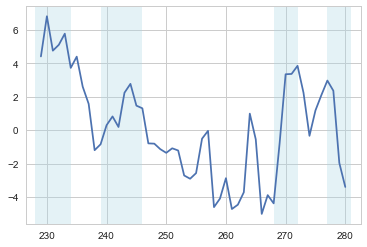

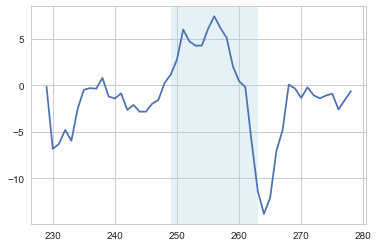

In [228]:
z = smooth(list(scores['beta']), n=2)
fig, ax = plt.subplots(1)
ax.plot(np.arange(228, 228+len(z)), z)

for (a,b) in gb1_betastrands:
    rect = patches.Rectangle((a,-10), b-a, 22, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
    ax.add_patch(rect)
    
z = smooth(list(scores['alpha']), n=4)
fig, ax = plt.subplots(1)
ax.plot(np.arange(228, 228+len(z)), z)

rect = patches.Rectangle((gb1_helix[0],-30), gb1_helix[1]-gb1_helix[0], 60, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
ax.add_patch(rect)

In [160]:
min(gb1_top['i'])

228

In [936]:
gb1_2ndary = compute_SS(gb1_top, fill=np.nan)
ww_2ndary = compute_SS(ww_top, fill=np.nan)
rrm_2ndary = compute_SS(rrm_top, fill=np.nan)

## Comparing predicted secondary structure to experimental

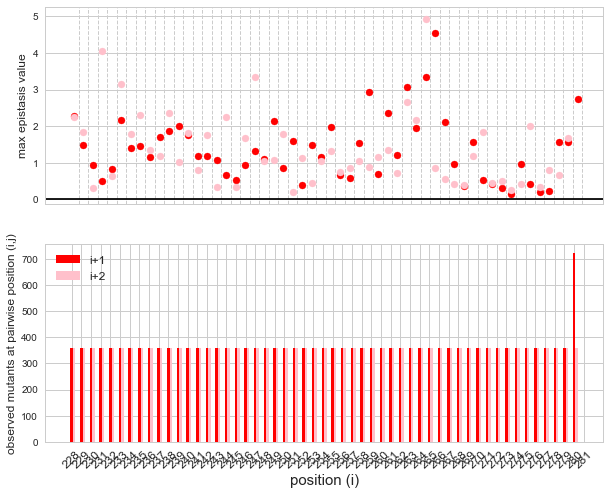

In [250]:
plot_beta_pairs(gb1, np.arange(228, 282))

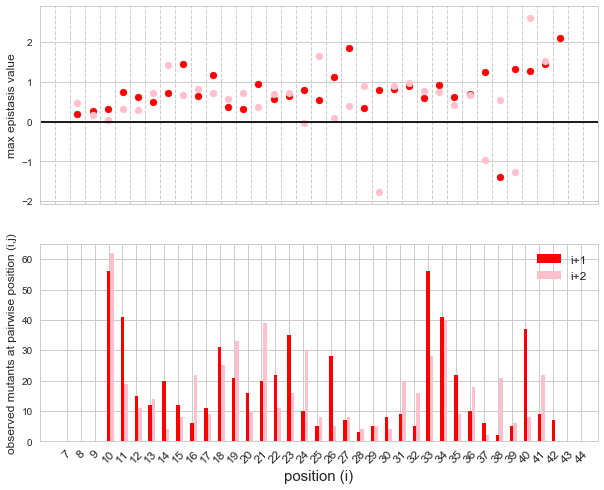

In [437]:
plot_beta_pairs(ww, np.arange(7, 45))

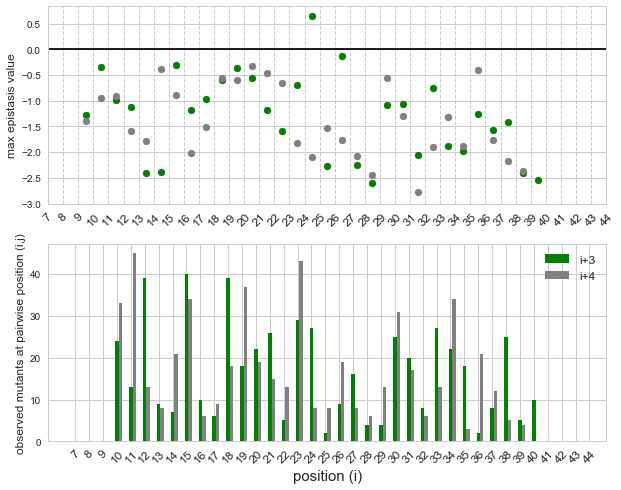

In [438]:
plot_alpha_pairs(ww, np.arange(7, 45))

# Precision vs epistasis rank

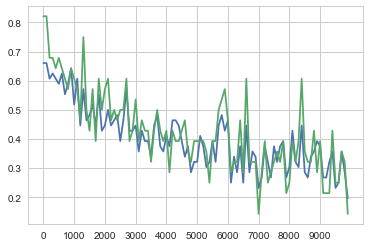

In [666]:
def rolling_top_L_precision(tbl, L, n = 100, M = 56):
    l = []
    for i in np.arange(L)[::n]:
        l.append(np.mean(tbl.tail(len(tbl) - i).drop_duplicates('positions').head(M)['dist'].lt(5)))
    return(l)
L = 10000
n = 100
M = 56
plt.plot(np.arange(L)[::n], rolling_top_L_precision(gb1[gb1['Input Count'].gt(20)].sort_values('epi', ascending=False), L, n, M))
M = 28
plt.plot(np.arange(L)[::n], rolling_top_L_precision(gb1[gb1['Input Count'].gt(20)].sort_values('epi', ascending=False), L, n, M))
plt.gca().set_xticks(np.arange(0, 10000)[::1000]);

/Users/nrollins/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


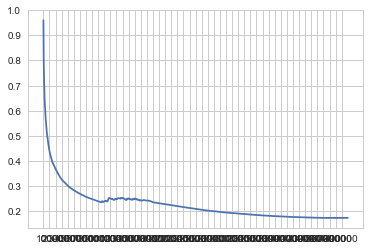

In [805]:
L = 500000

def rolling_precision(tbl, L, n = 100):
    l = []
    x = tbl['dist'].lt(5)
    for i in np.arange(L)[::n]:
        l.append(np.mean(x.head(i)))
    return(l)

plt.plot(np.arange(L)[::100], rolling_precision(gb1[gb1['Input Count'].gt(20)].sort_values('epi', ascending=False), L))
plt.gca().set_xticks(np.arange(0, 500000)[::10000]);

#plt.scatter(np.arange(L), rolling_local_precision(gb1[gb1['Input Count'].gt(20)].sort_values('epi', ascending=False), L), alpha=0.1, s=1)

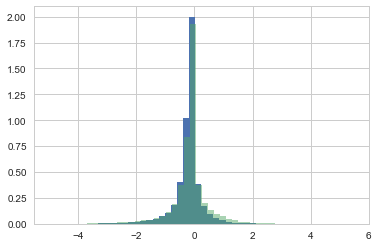

In [446]:
bins = plt.hist(gb1['epi'], bins=50, normed=True);
bins = plt.hist(gb1[gb1['dist'].lt(5)]['epi'], bins=50, normed=True, alpha=0.5);

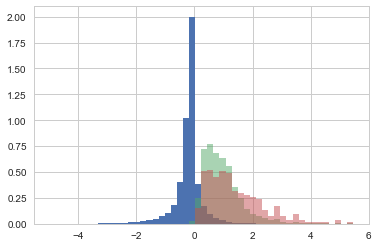

In [447]:
bins = plt.hist(gb1['epi'], bins=50, normed=True);
plt.hist(gb1_top['epi'], bins=bins[1], alpha=0.5, normed=True);
plt.hist(gb1_top[gb1_top['dist'].lt(5)]['epi'], bins=bins[1], alpha=0.5, normed=True);

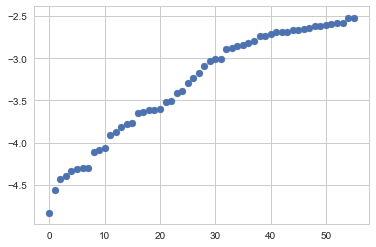

In [438]:
plt.scatter(np.arange(len(Y)), Y['epi'])

### <5A precision of top X pairs

In [631]:
def rolling_precision(tbl, L):
    l = []
    x = tbl['dist'].lt(5)
    for i in np.arange(L):
        l.append(np.mean(x.head(i)))
    return(l)


### distribution of distances in top L pairs versus $\epsilon$  > 1 pairs

In [1186]:
str(list(gb1_top[gb1_top['positions'].apply(lambda x: x[1]-x[0] > 5)]['dist'].lt(5).astype(int).head(56)))

'[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]'

# Precision of predictions from subsampled, sparse mutation scans 

### for evaluating precision, n=1000

In [56]:
dists = [a for a in gb1.keys() if 'dist' in a]
gb1.loc[:, 'dist.any'] = gb1.apply(lambda x: np.nanmin([x[a] for a in dists]), axis=1)

Any double mutant pair

In [57]:
Z = []
for n in [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.25, 0.5]:
    Y = draw_samples(gb1[gb1['Input Count'].gt(20)], int(n*len(gb1)), 1000,
                lambda x: most_epistatic_pairs(x))
    for i, y in enumerate(Y):
        prec = (n,
                np.mean(y['dist.2gb1'].head(28).lt(5)),
                np.mean(y['dist.2gb1'].head(56).lt(5)),
                np.mean(y[y['LR']]['dist.2gb1'].head(28).lt(5)),
                np.mean(y[y['LR']]['dist.2gb1'].head(56).lt(5)))
        Z.append(prec)

prec_any = pd.DataFrame(Z, columns=['library size', 'L/2', 'L', 'L/2 (i-j > 5)', 'L (i-j > 5)'])
prec_any.to_csv('../additional_data/gb1_subsampling/precision/any_pair-precision_n1000.csv', index=False)

In [35]:
prec_any.head()

,library size,L/2,L,L/2 (i-j > 5),L (i-j > 5)
0,0.005,0.428571,0.428571,0.321429,0.267857
1,0.005,0.642857,0.553571,0.535714,0.410714
2,0.005,0.500000,0.535714,0.357143,0.357143
3,0.005,0.500000,0.482143,0.357143,0.410714
4,0.005,0.535714,0.446429,0.392857,0.339286


Includes a deleterious mutant (lnWA or lnWB < -2)

In [58]:
Z = []
one_del = gb1['lnWs'].apply(lambda x: (x[0] < -2) or (x[1] < -2))
for n in [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.25]:
    Y = draw_samples(gb1[gb1['Input Count'].gt(20) & one_del], int(n*len(gb1)), 1000,
                lambda x: most_epistatic_pairs(x))
    for i, y in enumerate(Y):
        prec = (n,
                np.mean(y['dist.2gb1'].head(28).lt(5)),
                np.mean(y['dist.2gb1'].head(56).lt(5)),
                np.mean(y[y['LR']]['dist.2gb1'].head(28).lt(5)),
                np.mean(y[y['LR']]['dist.2gb1'].head(56).lt(5)))
        Z.append(prec)

one_del = pd.DataFrame(Z, columns=['library size', 'L/2', 'L', 'L/2 (i-j > 5)', 'L (i-j > 5)'])
one_del.to_csv('../additional_data/gb1_subsampling/precision/one_del-precision_n1000.csv', index=False)

Both mutants are deleterious (lnWA and lnWB < -2)

In [59]:
Z = []
del_pair = gb1['lnWs'].apply(lambda x: (x[0] < -2) and (x[1] < -2))
for n in [0.005, 0.01, 0.02, 0.05]:
    Y = draw_samples(gb1[gb1['Input Count'].gt(20) & del_pair], int(n*len(gb1)), 1000,
                lambda x: most_epistatic_pairs(x))
    for i, y in enumerate(Y):
        prec = (n,
                np.mean(y['dist.2gb1'].head(28).lt(5)),
                np.mean(y['dist.2gb1'].head(56).lt(5)),
                np.mean(y[y['LR']]['dist.2gb1'].head(28).lt(5)),
                np.mean(y[y['LR']]['dist.2gb1'].head(56).lt(5)))
        Z.append(prec)

prec_both = pd.DataFrame(Z, columns=['library size', 'L/2', 'L', 'L/2 (i-j > 5)', 'L (i-j > 5)'])
prec_both.to_csv('../additional_data/gb1_subsampling/precision/del_pair-precision_n1000.csv', index=False)

### for folding constraints, n=10

## additional mutation strategy: pairwise swaps

In [328]:
gb1_swaps = gb1[gb1['mut'].apply(lambda x: (x[0][-1] == x[1][0]) or (x[1][-1] == x[0][0])) & gb1['Input Count'].gt(20)]
gb1_swaps_top = gb1_swaps.sort_values('epi', ascending=False).drop_duplicates('positions', keep='first')

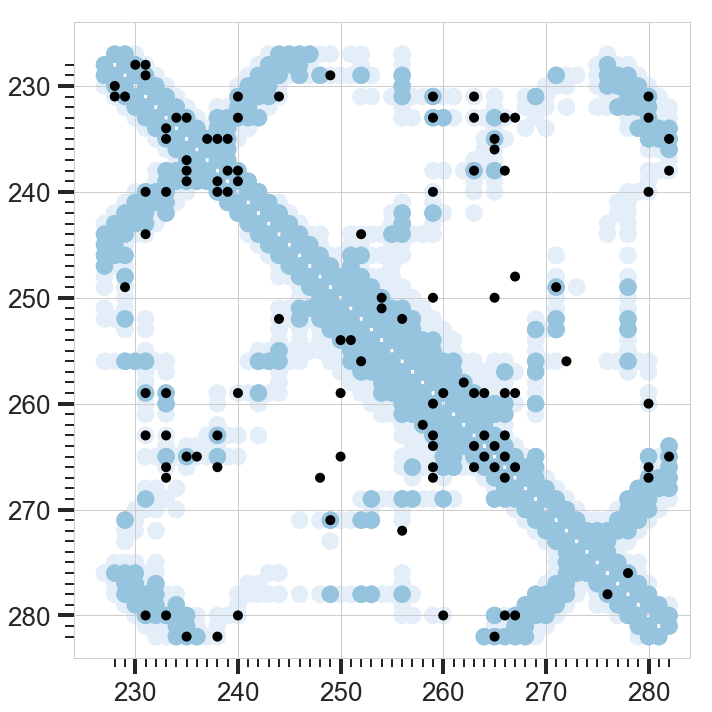

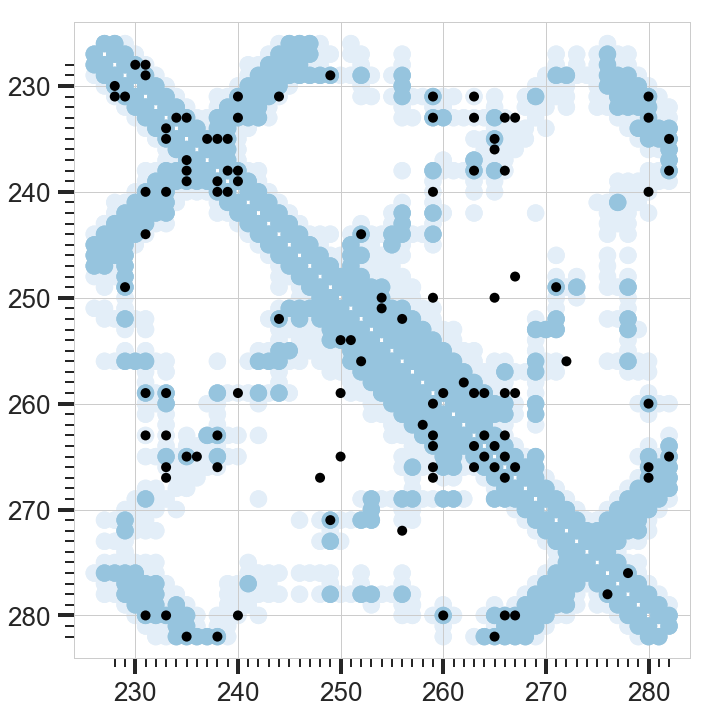

In [330]:
xt = gb1_xtals.reset_index()
xt.loc[:, 'positions'] = xt.apply(lambda x: (x['level_0'], x['level_1']), axis=1)

for d in ['2gb1', 'min_overall']:
    fig, ax = plotContacts(xt, lims=[226, 56+226], offset=226, dist=d, tixm=(228, 283), tixM=(230, 290))
    plotIJ(gb1_swaps_top.head(56), ax=ax, z=2, s=100)
    ax.tick_params(width=4, length=16, which='major')
    ax.tick_params(width=2, length=9, which='minor')
    fig.tight_layout()
    
    plt.grid(True, which='major')
    #fig.savefig('../additional_data/gb1_swaps-100-pairs-vs-'+d+'_10grid-b10.svg')

# GB1 epistasis fold prediction versus experimental structures

## model vs any experimental structure - RMSD

## contact map overlap